<a href="https://colab.research.google.com/github/DataScience-Challenge-Group1/Data-Science-Challenge-Hackathon/blob/main/notebooks/hackathon_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training shape: (4756, 31)
Testing shape: (4749, 30)
seasonal_vaccine
1    0.536375
0    0.463625
Name: proportion, dtype: float64


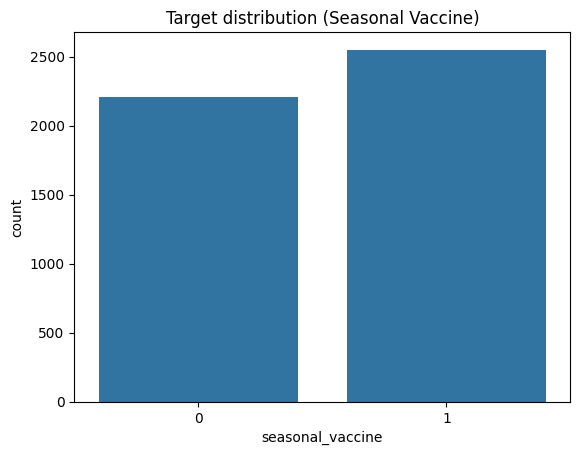

[LightGBM] [Info] Number of positive: 2040, number of negative: 1764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 3804, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536278 -> initscore=0.145366
[LightGBM] [Info] Start training from score 0.145366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [12]:
# === Part 1 : MICE Imputation + Supervised Model (LightGBM) ===

# Install required libraries
!pip install lightgbm shap pdpbox --quiet

# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load datasets ---
train = pd.read_csv("/content/drive/MyDrive/Hackathon/dataset_A_training.csv")
test  = pd.read_csv("/content/drive/MyDrive/Hackathon/dataset_A_testing.csv")


TARGET = 'seasonal_vaccine'
ID_COL = 'respondent_id'

print("Training shape:", train.shape)
print("Testing shape:", test.shape)

# --- Basic EDA ---
print(train[TARGET].value_counts(normalize=True))
sns.countplot(x=TARGET, data=train)
plt.title("Target distribution (Seasonal Vaccine)")
plt.show()

# --- Separate features/target ---
X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET]

# --- Identify categorical and numerical columns ---
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# --- Step 1: Preprocessing pipeline (One-Hot Encode categorical, then MICE impute numerical) ---
# Create a pipeline for preprocessing
# We need to re-apply one-hot encoding to get the correct column names after imputation
preprocess_final = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42), num_cols)
])

# --- Step 2: Create a full pipeline including preprocessing and model ---
full_pipeline = Pipeline([
    ('preprocessor', preprocess_final),
    ('classifier', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


# --- Step 3: Split train/validation ---
# Use X and y for splitting as preprocessing is now in the pipeline
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 4: Train the full pipeline ---
full_pipeline.fit(X_train, y_train)

# --- Step 5: Evaluate on validation set ---
y_pred = full_pipeline.predict(X_val)
y_prob = full_pipeline.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_prob))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# --- Step 6: Predict on test set ---
# Apply the full pipeline to the test set
y_test_pred = full_pipeline.predict_proba(test.drop(columns=[ID_COL], errors='ignore'))[:, 1]

submission = pd.DataFrame({ID_COL: test[ID_COL], TARGET: y_test_pred})
submission.to_csv('LGBM_MICE_submission.csv', index=False)
print("✅ Saved LGBM_MICE_submission.csv")

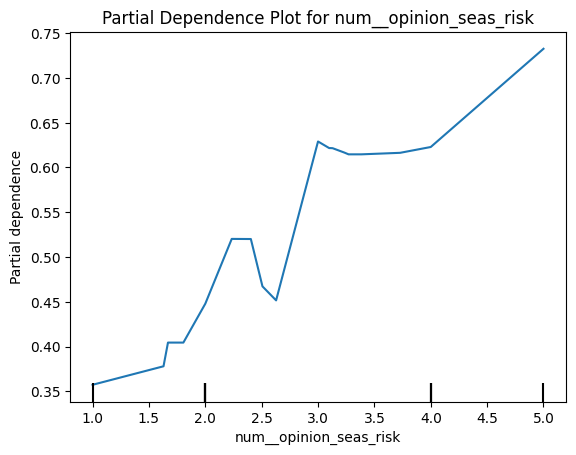

In [16]:
# --- Partial Dependence Plot using sklearn.inspection ---
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use your fitted full pipeline (full_pipeline)
model = full_pipeline.named_steps["classifier"] # Access the classifier from the pipeline

# Preprocess the validation data using the fitted preprocessor from the pipeline
X_val_prep = full_pipeline.named_steps['preprocessor'].transform(X_val)
X_val_prep = pd.DataFrame(X_val_prep, columns=full_pipeline.named_steps['preprocessor'].get_feature_names_out())


# Choose a feature (based on permutation importance)
# Ensure the feature name exists in the preprocessed data
top_feature = "num__opinion_seas_risk"  # Example, replace if needed

# Get feature index after preprocessing
# The feature name should match one of the columns in X_val_prep
if top_feature in X_val_prep.columns:
    feat_idx = list(X_val_prep.columns).index(top_feature)
else:
    print(f"Feature '{top_feature}' not found in preprocessed data.")
    feat_idx = None

# Plot Partial Dependence
if feat_idx is not None:
    PartialDependenceDisplay.from_estimator(
        model,
        X_val_prep,
        [feat_idx],
        feature_names=X_val_prep.columns,
        kind="average"
    )

    plt.title(f"Partial Dependence Plot for {top_feature}")
    plt.show()
else:
    print("Partial Dependence Plot cannot be generated without a valid feature.")